In [3]:
#  This progrom computes the PCA and PLS indices of investor sentiment
#  and see how it predicts the stock market

import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import statsmodels.api as sm
from sklearn.preprocessing import scale 

First few data 

        date       pdnd       cefd      ripo       nipo         s
0 1965-07-31  31.123778  19.274681  6.244944  10.333333  0.153472
1 1965-08-31  30.705603  19.479926  5.968817  10.083333  0.137691
2 1965-09-30  30.157715  18.845566  5.289247  10.833333  0.138454
3 1965-10-31  30.120378  17.532712  5.667742  11.083333  0.137525
4 1965-11-30  30.396602  16.818206  5.719355  12.083333  0.125939

 data type 
 date    datetime64[ns]
pdnd           float64
cefd           float64
ripo           float64
nipo           float64
s              float64
dtype: object

 Standardized data 

        date      pdnd      cefd      ripo      nipo         s
0 1965-07-31 -2.584259 -1.516830 -0.796294 -0.770844 -0.175203
1 1965-08-31 -2.553784 -1.547349 -0.816849 -0.783483 -0.346998
2 1965-09-30 -2.513855 -1.453022 -0.867439 -0.745566 -0.338693
3 1965-10-31 -2.511134 -1.257807 -0.839262 -0.732927 -0.348811
4 1965-11-30 -2.531264 -1.151563 -0.835420 -0.682371 -0.474931


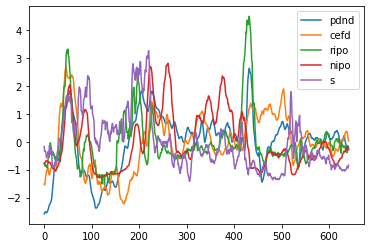

In [9]:
### load data of the 5 sentiment proxies into python

BW = pd.read_excel('HJTZ_PLS_Sentiment_proxies2019.xlsx')
                         #1965/07 to 2018/12, 642 monthly obesrvations 

# See the first few
print('First few data \n')
print (BW.head())   

print('\n data type \n' , BW.dtypes)


### make sure high values --> high sentiment
# multiply 2 colums, close-end-fund-discount&dividend-paying-premium, by (-1)
BW[['pdnd','cefd']] = BW[['pdnd','cefd']] * -1
    

# note that PLS is sensitive to data-scaling
# It requires to standardize the data to mean 0, std 1
cols_sent = ['pdnd','cefd', 'ripo','nipo','s']    # to apply to all 5 columns of data
BW[cols_sent]= BW[cols_sent].apply(zscore)

print('\n Standardized data \n' )
print (BW.head())  

### take a look
BW[cols_sent].plot()


In [5]:
#  PCA; PCR.  We care only the first factor here
#  In general, tests or cross-validation may be used to determine K

X = BW[cols_sent]  
        # note X=BW will not work in array input for PCA function, 
           # as BW has headings and dates in the first column
print('Input Dimensionality:  T by 5 ')
print(X.shape)     # T by 5 
 
pca = PCA(n_components=1)     # we consider only K=1
X_new = pca.fit_transform(X)   # as our data are standardized already
 

print('\n Output # of rows and columns for X_new, and the 1st 5 rows of PCR ')
print(len(X_new), len(X_new[0]))
print(X_new[0:5])      # cannot use .head attribute as X_new is an array
mu = np.mean(X_new) 
var = np.var(X_new)
print(' Its mean and std  ', mu, np.sqrt(var))

print('\n explained_variance_ratio  ')
print(pca.explained_variance_ratio_)

# Get the loadings or the weights on the 5 components
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
print('\n the loadings  ')
print(loadings)

Input Dimensionality:  T by 5 
(642, 5)

 Output # of rows and columns for X_new, and the 1st 5 rows of PCR 
642 1
[[-2.97350023]
 [-3.00183896]
 [-2.93849336]
 [-2.82690021]
 [-2.77563586]]
 Its mean and std   2.2135287718383183e-17 1.5311854669568288

 explained_variance_ratio  
[0.46890579]

 the loadings  
[[0.90165592]
 [0.72448913]
 [0.69837537]
 [0.70750638]
 [0.14840889]]


In [6]:
#  PLS.  We care only the first factor here.

Factors = pd.read_excel('Factors_July1965_Jan_2019.xlsx')  # data from French's web
                         #1965/07 to 2018/12, 642 monthly obesrvations on FF 3 factors
    
Y = Factors['Mkt']/100    # Mkt excess return;  divided by 100 due to data are in %
print(Y.shape)
print(Y.head)
 
pls = PLSRegression(n_components = 1) 
 
pls.fit (X,Y)  # Note that PLSRegression is invariant to scaling Y or not
                              # at least in the one target case
Fpls = pls.transform(X)

mu = np.mean(Fpls) 
var = np.var(Fpls)


print('\n the PLS factor  ')
print(Fpls[0:4])
print(' Its mean and std  ', mu, np.sqrt(var))

Y_pred = pls.predict(X)    # the predicted y values
print('\n the predicted y values  ')
print(Y_pred[0:4])

(642,)
<bound method NDFrame.head of 0      0.0273
1      0.0286
2      0.0260
3     -0.0003
4      0.0101
        ...  
637    0.0006
638   -0.0768
639    0.0169
640   -0.0955
641    0.0841
Name: Mkt, Length: 642, dtype: float64>

 the PLS factor  
[[-1.18252002]
 [-1.31537866]
 [-1.31724332]
 [-1.2598835 ]]
 Its mean and std   2.2135287718383183e-17 1.180125873372075

 the predicted y values  
[[0.01146014]
 [0.01216894]
 [0.01217889]
 [0.01187287]]


In [7]:
#  PLS. Second approach,  directly from the average forecast (see the Lecture Notes) without the pls function

# compute first the covariances (X_j, Y)'s  or X'Y

YS = scale (Y)       # we standardize Y here to get the correlations as in the Lecture Notes
XX = X.to_numpy()    # convert daraframe to array to use matrix multiplication function
T = len(XX)
C = np.matmul(XX.T,YS) / T   # sample covariances; loadings for the PLS
 
print(C)

f = np.matmul(XX,C.T) 

print(' PLS factor  \n')
print(len(f))
print(f[0:5])



[-0.00106985 -0.03507355 -0.11789461 -0.03746319 -0.106141  ]
 PLS factor  

642
[0.19731866 0.21948783 0.21979897 0.21022775 0.2175624 ]


In [8]:
# Comparison of R^2  

const = np.ones((T,1))           # The constant part

xx = np.hstack((const,X_new))         # Add the constant part to x
reg = sm.OLS(endog=Y, exog=xx)  # Y on PCA factor
results = reg.fit()
print('\n PCA R^2  ', results.rsquared)  

xx = np.hstack((const,Fpls))
reg = sm.OLS(endog=Y, exog=xx)  # Y on PLS factor
results = reg.fit()
print('\n PLS R^2  ', results.rsquared)    

print(Fpls.shape)
print(f.shape)
f.shape=(642,1)     # set shape to (642,1)
xx = np.hstack((const,f))
reg = sm.OLS(endog=Y, exog=xx)  # Y on PLS factor, 2nd approach
results = reg.fit()
print('\n PLS R^2, 2nd approach  ', results.rsquared)


 PCA MSE   0.004139790960744905

 PLS MSE   0.019930061407869792
(642, 1)
(642,)

 PLS MSE, 2nd approach   0.019930061407869792
